# In this notebook we visualize effects of inserting a single CTCF in multiple backgrounds

In [1]:
import bioframe
import pandas as pd
import numpy as np
import tensorflow as tf
from basenji import dna_io
import akita_utils
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import h5py
# sns.set_theme()
import akita_utils.format_io

# Importing scores from simulations

In [2]:
def load_data(h5_dirs, scd_stats, models=[1]):
    
    model_dfs = {} 
    for h5_num, h5_file in enumerate(glob.glob(h5_dirs)):
        
        for model in models:
            if f"model{model}_h" in h5_file:  
                df = akita_utils.format_io.h5_to_df(h5_file, scd_stats, drop_duplicates_key=None)
                if f"model{model}" in model_dfs.keys():
                    model_dfs[f"model{model}"] = pd.concat([model_dfs[f"model{model}"], df])
                else:
                    model_dfs[f"model{model}"] = df  
            
    # merged_df = pd.DataFrame()
    for df_num,df in enumerate(model_dfs.values()):
        if df_num ==0:
            merged_df = df
        else:
            merged_df = pd.merge(merged_df, df, on=['CTCF_1_insert',"background_seqs"], how='inner', suffixes=("",f"_{df_num}"))
    
    if 'merged_df' not in locals():
        print("Error: merged_df is empty. Cannot perform further calculations.")
        exit(1)
    else:
        for stat in scd_stats:
            for model in models:
                merged_df[f"mean_{stat}_score_m{model}"] = (
                      merged_df[f"{stat}_h1_m{model}_t0"]
                    + merged_df[f"{stat}_h1_m{model}_t1"]
                    + merged_df[f"{stat}_h1_m{model}_t2"]
                    + merged_df[f"{stat}_h1_m{model}_t3"]
                    + merged_df[f"{stat}_h1_m{model}_t4"]
                    + merged_df[f"{stat}_h1_m{model}_t5"]
                ) / 6

            # Calculate mean score over models for current statistic
            mean_score = np.mean([
                merged_df[f"mean_{stat}_score_m{model}"] for model in models
            ], axis=0)

            # Add mean score column to DataFrame
            merged_df[f"mean_{stat}_score"] = mean_score

        return merged_df.reset_index(drop=True)


In [3]:
uniformly_selcted_model2_motifs_h5_dirs = (
 # "/scratch1/kamulege/insert_experiments/12_uniformly_selcted_model2_motifs/*/*/*.h5"
    "/scratch1/kamulege/insert_experiments/11_uniformly_selcted_model6_motifs_v2/*/*/*.h5"
)

uniformly_selcted_model2_motifs_df = load_data(uniformly_selcted_model2_motifs_h5_dirs, scd_stats=["SCD", "SSD"], models=[2,3,4,5,6,7])

# uniformly_selcted_model2_motifs_df

In [4]:
# uniformly_selcted_model1_motifs_h5_dirs = (
#  "/scratch1/kamulege/insert_experiments/1000_uniformly_selcted_model1_motifs/*/*/*.h5"
# )

# uniformly_selcted_model1_motifs_df = load_data(uniformly_selcted_model1_motifs_h5_dirs, scd_stats=["SCD", "SSD"], models=[1])

# uniformly_selcted_model1_motifs_df

In [5]:
motifs_df = uniformly_selcted_model2_motifs_df

# motifs_df.columns

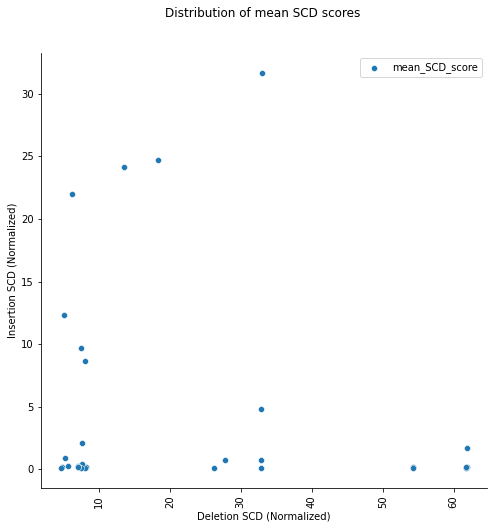

In [6]:
# normalize the data

max_ctcf = motifs_df['CTCF_1_genomic_SCD'].max()
max_mean_scd = motifs_df['mean_SCD_score'].max()
motifs_df['CTCF_1_genomic_SCD_norm'] = motifs_df['CTCF_1_genomic_SCD'] / max_ctcf
motifs_df['mean_SCD_score_norm'] = motifs_df['mean_SCD_score'] / max_mean_scd

# create the plot
fig, ax = plt.subplots(figsize=(8, 8)) #, dpi=200

# data = motifs_df[(motifs_df['mean_SCD_score_norm']>0.8) & (motifs_df['CTCF_1_genomic_SCD_norm']<0.5)]
data = motifs_df
# display(data)

# sns.scatterplot(data=data, ax=ax, x="CTCF_1_genomic_SCD_norm", y="mean_SCD_score_norm", label="mean_SCD_score")
sns.scatterplot(data=data, ax=ax, x="CTCF_1_genomic_SCD", y="mean_SCD_score", label="mean_SCD_score")

sns.despine(top=True, right=True)
plt.xticks(rotation=90)
plt.title("Distribution of mean SCD scores \n \n ")

# Add bands for high and low correlation
# sns.regplot(data=motifs_df, ax=ax, x="CTCF_1_genomic_SCD_norm", y="mean_SCD_score_norm", scatter=False, color="red", label="High Correlation")
# sns.regplot(data=motifs_df, ax=ax, x="CTCF_1_genomic_SCD_norm", y="mean_SCD_score_norm", scatter=False, color="blue", label="Low Correlation")

plt.xlabel("Deletion SCD (Normalized)")
plt.ylabel("Insertion SCD (Normalized)")
plt.legend()
plt.show()



In [7]:
# [i for i in range(-1000,1050,50)]


In [8]:
# # Calculate correlation between two columns
# corr = df['column1'].corr(df['column2'])

# # Check if correlation coefficient is close to zero
# if abs(corr) < 0.1:
#     # Select corresponding points for further analysis
#     selected_points = df.loc[(df['column1'] == some_value) & (df['column2'] == some_other_value)]

In [9]:
def collect_h5(file_name, out_dir, num_procs):
    # count variants
    num_variants = 0
    for pi in range(num_procs):
        # open job
        job_h5_file = "%s/job%d/%s" % (out_dir, pi, file_name)
        job_h5_open = h5py.File(job_h5_file, "r")
        # print(job_h5_open)
        num_variants += len(job_h5_open["chrom"]) #chrom_core
        job_h5_open.close()

    # initialize final h5
    final_h5_file = "%s/%s" % (out_dir, file_name)
    final_h5_open = h5py.File(final_h5_file, "w")

    # keep dict for string values
    final_strings = {}

    job0_h5_file = "%s/job0/%s" % (out_dir, file_name)
    job0_h5_open = h5py.File(job0_h5_file, "r")
    for key in job0_h5_open.keys():
        if key in ["target_ids", "target_labels"]:
            # copy
            final_h5_open.create_dataset(key, data=job0_h5_open[key])

        elif job0_h5_open[key].dtype.char == "S":
            final_strings[key] = []

        elif job0_h5_open[key].ndim == 1:
            final_h5_open.create_dataset(
                key, shape=(num_variants,), dtype=job0_h5_open[key].dtype
            )

        else:
            num_targets = job0_h5_open[key].shape[1]
            final_h5_open.create_dataset(
                key, shape=(num_variants, num_targets), dtype=job0_h5_open[key].dtype
            )

    job0_h5_open.close()

    # set values
    vi = 0
    for pi in range(num_procs):
        # open job
        job_h5_file = "%s/job%d/%s" % (out_dir, pi, file_name)
        job_h5_open = h5py.File(job_h5_file, "r")

        # append to final
        for key in job_h5_open.keys():
            if key in ["target_ids", "target_labels"]:
                # once is enough
                pass

            else:
                if job_h5_open[key].dtype.char == "S":
                    final_strings[key] += list(job_h5_open[key])
                else:
                    job_variants = job_h5_open[key].shape[0]
                    final_h5_open[key][vi : vi + job_variants] = job_h5_open[key]

        vi += job_variants
        job_h5_open.close()

    # create final string datasets
    for key in final_strings:
        final_h5_open.create_dataset(key, data=np.array(final_strings[key], dtype="S"))

    final_h5_open.close()

In [94]:

collect_h5("scd.h5", "/scratch1/kamulege/disruption_genomic_scds/motif_expt_model6_head1", 10)


In [95]:

h5_dirs_2 = "/scratch1/kamulege/disruption_genomic_scds/motif_expt_model1_head1/scd.h5"

h5_dirs_1 = "/scratch1/kamulege/disruption_genomic_scds/motif_expt_model6_head1/scd.h5"

# h5_dirs_1 = "/project/fudenber_735/tensorflow_models/akita/v2/analysis/permute_boundaries_motifs_ctcf_mm10_model7/scd.h5"

sites_1 = akita_utils.tsv_gen_utils.filter_boundary_ctcfs_from_h5(
        h5_dirs=h5_dirs_1, score_key="SCD", threshold_all_ctcf=-np.inf,
    )
sites_2 = akita_utils.tsv_gen_utils.filter_boundary_ctcfs_from_h5(
        h5_dirs=h5_dirs_2, score_key="SCD", threshold_all_ctcf=-np.inf,
    )

annotating each site with boundary-wide scores
annotating each site with boundary-wide scores


Text(0, 0.5, 'sites_2 score')

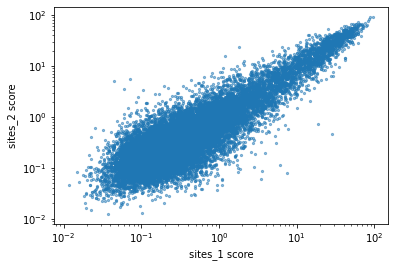

In [96]:
pseudocount=1e-3
plt.scatter(
    sites_1['SCD']+pseudocount,
    sites_2['SCD']+pseudocount,
    5, alpha=0.5)
plt.loglog()
plt.xlabel('sites_1 score')
plt.ylabel("sites_2 score")

18141
18141


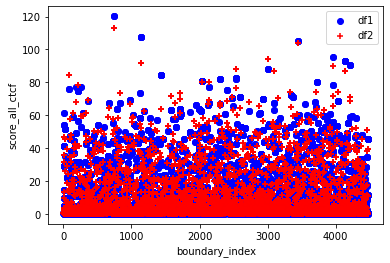

In [97]:
print(len(sites_1["score_all_ctcf"]))  
print(len(sites_2["score_all_ctcf"]))

# create a scatter plot for df1
plt.scatter(sites_1['boundary_index'], sites_1['score_all_ctcf'], label='df1', color='blue', marker='o')

# create a scatter plot for df2
plt.scatter(sites_2['boundary_index'], sites_2['score_all_ctcf'], label='df2', color='red', alpha=1, marker='+') 
# score_10k score_all_ctcf
plt.xlabel("boundary_index")
plt.ylabel("score_all_ctcf")
# plt.ylim(0,5)
plt.legend()

In [ ]:
# score_key="SCD"
# upper_threshold=99
# lower_threshold=1
# mode="head"

# upper_thresh = np.percentile(sites[score_key].values, upper_threshold)
# lower_thresh = np.percentile(sites[score_key].values, lower_threshold)

# filtered_sites = (
#     sites[(sites[score_key] >= lower_thresh) & (sites[score_key] <= upper_thresh)]
#     .copy()
#     # .drop_duplicates(subset=[score_key])
#     .sort_values(score_key, ascending=False)
# )

In [ ]:
# len(filtered_sites)

In [ ]:
df_1 = pd.read_csv('/project/fudenber_735/tensorflow_models/akita/v2/analysis/boundaries.motifs.ctcf.mm10.tsv', sep='\t')
df_2 = pd.read_csv('/scratch1/kamulege/boundaries.motifs.ctcf.mm10.tsv', sep='\t')
df_3 = pd.merge(df_1, df_2, on="start" )

In [ ]:
not_in_df_2 = df_1[~df_1['span'].isin(df_2['span'])]

not_in_df_2

In [ ]:
# df_3.plot.scatter(x='start_x', y='start_y')

# create a scatter plot for df1
plt.scatter(df_1['boundary_index'], df_1['boundary_strength_200000'], label='df1', color='blue', marker='o')

# create a scatter plot for df2
plt.scatter(df_2['boundary_index'], df_2['boundary_strength_200000'], label='df2', color='red', marker='+')

plt.scatter(not_in_df_2['boundary_index'], not_in_df_2['boundary_strength_200000'], label='not_in_df_2', color='orange', alpha=1, marker='+')

plt.xlabel("boundary_index")
plt.ylabel("boundary_strength_200000")
plt.legend()

In [ ]:
df_1.shape[0] - df_2.shape[0]